In [1]:
from hblteuk import RadialTeukolsky, HyperboloidalTeukolsky
from swsh import SpinWeightedSpheroidalHarmonic
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rc('text', usetex=True)
mpl.rc('font', **{'size' : 24})
import numpy as np
import math

In [2]:
s = -2
a = 0.9
l = 40
m = 2
omega = 1.34831

In [3]:
def sigma_temp(a, r):
    kappa = np.sqrt(1-a**2)
    return 2.*kappa/(r - (1. - kappa))

In [4]:
hbl = HyperboloidalTeukolsky(a, s, l, m, omega)
hbl.solve(subdomains = 1, chebyshev_samples=100, cutoff=[sigma_temp(a,4.),sigma_temp(a,4.)])

In [5]:
Psihbl = hbl()

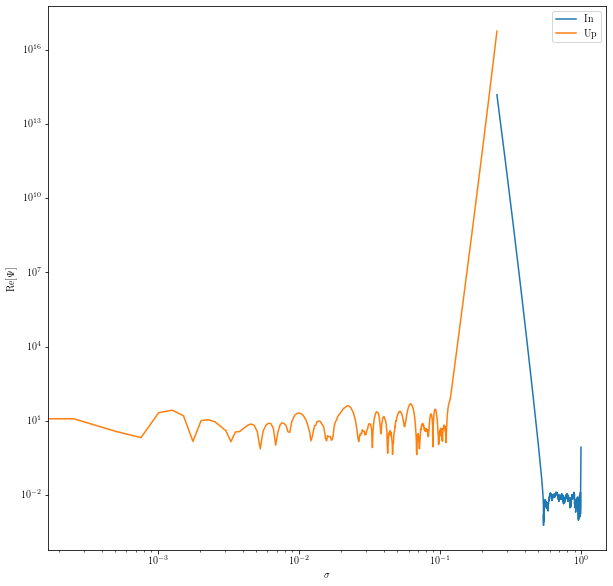

In [6]:
plt.figure(figsize=(10,10))
plt.loglog(*np.abs(np.abs(Psihbl['In'].linspace(1000))), label='In')
plt.loglog(*np.abs(np.abs(Psihbl['Up'].linspace(1000))), label='Up')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'Re[$\Psi$]')
plt.legend()
plt.show()

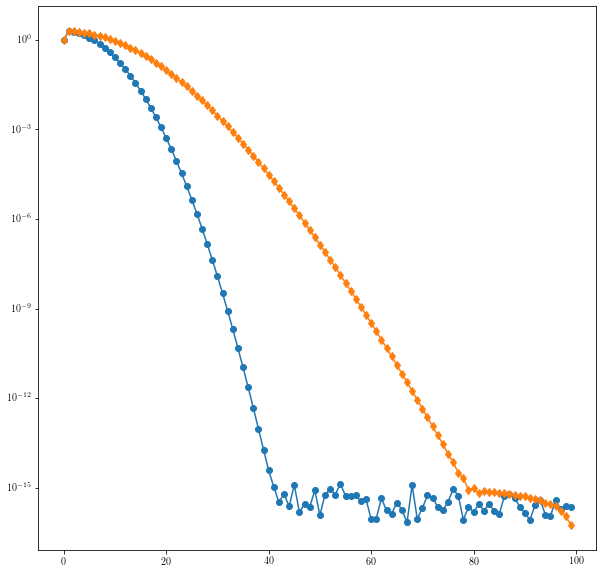

In [7]:
plt.figure(figsize=(10, 10))
for i in range(hbl.mch['Up'].coeffs.shape[0]):
    plt.plot(np.abs(hbl.mch['Up'].coeffs[i])/np.abs(hbl.mch['Up'].coeffs[i][0]), 'o-')
    plt.plot(np.abs(hbl.mch['In'].coeffs[i])/np.abs(hbl.mch['In'].coeffs[i][0]), 'd-')
plt.yscale('log')
plt.show()

In [8]:
import kerrgeopy as kg

In [9]:
def generate_frequencies(a, p, e, x, constants):
    upR = kg.frequencies.r_frequency(a, p, e, x, constants)
    upTh = kg.frequencies.theta_frequency(a, p, e, x, constants)
    upPh = kg.frequencies.phi_frequency(a, p, e, x, constants, upR, upTh)
    gamma = kg.frequencies.gamma(a, p, e, x, constants, upR, upTh)
    return np.array((gamma, upR, upTh, upPh))

In [10]:
class MiniGeo:
    def __init__(self, a, p, e, x):
        self.a = a
        self.p = p
        self.e = e
        self.x = x
        self.constants = kg.constants.constants_of_motion(a, p, e, x)
        self.En = self.constants[0]
        self.Lz = self.constants[1]
        self.Qc = self.constants[2]
        self.radial_roots = kg.constants.stable_radial_roots(a, p, e, x, self.constants)
        self.mino_frequencies = generate_frequencies(a, p, e, x, self.constants)
        self.frequencies = self.mino_frequencies[1:]/self.mino_frequencies[0]
        self.radial_solutions = kg.stable.radial_solutions(a, self.constants, self.radial_roots)

    def r(self, qr):
        return self.radial_solutions[0](qr)

    def tr(self, qr):
        return self.radial_solutions[1](qr)

    def phir(self, qr):
        return self.radial_solutions[2](qr)

    def ur(self, qr):
        r = self.r(qr)
        Delta = r**2 - 2.*r + self.a**2
        return np.sign(np.sin(qr))*((self.En*(r**2 + self.a**2) - self.a*self.Lz)**2 - Delta*(r**2 + (self.Lz - self.a*self.En)**2 + self.Qc))
    
    def r_velocity(self, qr):
        return self.ur(qr)/self.r(qr)**2

    def mode_frequency(self, m, k, n):
        return np.dot(self.frequencies, (n, k, m))

In [11]:
def scalar_source_equatorial(l, m, n, geo, nsamples = 2**9):
    omega = geo.mode_frequency(m, 0, n)
    a = geo.a
    Sslm = SpinWeightedSpheroidalHarmonic(0, l, m, a*omega)
    th = np.array([0.5*np.pi])
    Seq = Sslm(th)[0]

    hbl = HyperboloidalTeukolsky(a, 0, l, m, omega)
    rmin = geo.radial_roots[1]
    rmax = geo.radial_roots[0]
    smin = hbl.sigma_of_r(rmax)
    smax = hbl.sigma_of_r(rmin)
    # print(f"smin = {smin}, smax = {smax}")
    hbl.solve(cutoff=[smin, smax])

    Psihbl = hbl()
    phase_points = np.linspace(0, 2.*np.pi, nsamples + 1)[:-1]
    radial_points = geo.r(phase_points)
    sigma_points = hbl.sigma_of_r(radial_points)
    PsiUp = Psihbl["Up"](sigma_points)
    PsiIn = Psihbl["In"](sigma_points)
    Sigma = radial_points**2 
    Gamma = geo.mino_frequencies[0]
    Phase = n*phase_points + omega*geo.tr((1+1e-14)*phase_points) - m*geo.phir(phase_points)
    # Phase = omega*geo.tr((1+1e-14)*phase_points) - m*geo.phir(phase_points)

    wronskian = Psihbl["In"](smax)*Psihbl["Up"](smax, deriv = 1) - Psihbl["Up"](smax)*Psihbl["In"](smax, deriv = 1)
    const_wronskian = hbl.Zsigma(smax)**2*(rmin**2 - 2.*rmin + a**2)*hbl.dsigma_dr(rmin)*wronskian

    sourceFactor = -4*np.pi/Gamma*Seq*np.exp(1j*Phase)*Sigma*hbl.Zsigma(sigma_points)/const_wronskian

    return [sourceFactor*PsiUp, sourceFactor*PsiIn]


In [12]:
geo = MiniGeo(0.9, 7., 0.4, 1.)
np.mean(scalar_source_equatorial(12, 2, 4, geo, nsamples=2**10), axis = 1)

array([-1.6102121e-16-1.24961280e-17j,  6.0629307e-13-2.09462369e-12j])

In [13]:
def gravitational_source_equatorial(l, m, n, geo, nsamples = 2**9):
    omega = geo.mode_frequency(m, 0, n)
    a = geo.a
    En, Lz, Qc = geo.constants
    Sslm = SpinWeightedSpheroidalHarmonic(-2, l, m, a*omega)
    th = 0.5*np.pi
    uth = 0.
    Seq = Sslm(np.array([th]))[0]
    sth = np.sin(th)
    cth = np.cos(th)

    dSeq = Sslm.deriv(np.array([th]))[0]
    d2Seq = Sslm.deriv2(np.array([th]))[0]

    L1 = -m/sth + a*omega*sth + cth/sth
    L2 = -m/sth + a*omega*sth + 2.*cth/sth
    L2S = dSeq + L2*Seq
    L2p = m*cth/sth**2 + a*omega*cth - 2./sth**2
    L1Sp = d2Seq + L1*dSeq
    L1L2S = L1Sp + L2p*Seq + L2*dSeq + L1*L2*Seq

    hbl = HyperboloidalTeukolsky(a, -2, l, m, omega)
    rmin = geo.radial_roots[1]
    rmax = geo.radial_roots[0]
    smin = hbl.sigma_of_r(rmax)
    smax = hbl.sigma_of_r(rmin)
    hbl.solve(cutoff=[smin, smax])
    
    Psihbl = hbl()
    qr = np.linspace(0, 2.*np.pi, nsamples + 1)[:-1]
    rp = geo.r(qr)
    urp = geo.ur(qr)

    sp = hbl.sigma_of_r(rp)
    PsiUp = Psihbl["Up"](sp)
    PsiIn = Psihbl["In"](sp)
    dPsiUp = Psihbl["Up"](sp, deriv=1)
    dPsiIn = Psihbl["In"](sp, deriv=1)
    d2PsiUp = Psihbl["Up"](sp, deriv=2)
    d2PsiIn = Psihbl["In"](sp, deriv=2)

    Delta = rp**2 - 2.*rp + a**2
    DeltaSqrt2 = np.sqrt(2)*Delta
    Kt = (rp**2 + a**2)*omega - m*a
    rho = -1./(rp - 1j*a*cth)
    rhobar = -1./(rp + 1j*a*cth)
    Sigma = 1/rho/rhobar

    Ann0 = -rho**(-2)*rhobar**(-1)*DeltaSqrt2**(-2)*(rho**(-1)*L1L2S + 3j*a*sth*L1*Seq + 3j*a*cth*Seq + 2j*a*sth*dSeq - 1j*a**sth*L2*Seq)
    Anmbar0 = rho**(-3)*DeltaSqrt2**(-1)*((rho + rhobar - 1j*Kt/Delta)*L2S + (rho - rhobar)*a*sth*Kt/Delta*Seq)
    Anmbar1 = -rho**(-3)*DeltaSqrt2**(-1)*( L2S + 1j*(rho - rhobar)*a*sth*Seq)
    Ambarmbar0 = rho**(-3)*rhobar*DeltaSqrt2**(-2)*(0.5*Kt**2 + 1j*Kt*(1. - rp + Delta*rho) + 1j*rp*omega*Delta)*Seq
    Ambarmbar1 = -0.5*(rho)**(-3)*rhobar*(1j*Kt/Delta - rho)*Seq
    Ambarmbar2 = -0.25*(rho)**(-3)*rhobar*Seq

    Cr = (En*(rp**2 + a**2) - a*Lz + urp)/(2*Sigma)
    Cth = a*(1j*sth*(a*En - Lz/sth**2) + uth)/np.sqrt(2)

    Cnn = Cr*Cr
    Cnmbar = Cr*Cth
    Cmbarmbar = Cth*Cth

    rphase = omega*geo.tr((1. + 1e-14)*qr) - m*geo.phir(qr) + n*qr

    A0 = Ann0*Cnn + Anmbar0*Cnmbar + Ambarmbar0*Cmbarmbar
    A1 = Anmbar1*Cnmbar + Ambarmbar1*Cmbarmbar
    A2 = Ambarmbar2*Cmbarmbar

    Zs = hbl.Zsigma(sp)
    dZs = hbl.Zsigma_deriv(sp)
    d2Zs = hbl.Zsigma_deriv2(sp)

    gs = hbl.dsigma_dr_of_sigma(sp)
    dgs = hbl.dsigma_dr_of_sigma_deriv(sp)

    B0 = A0*Zs + gs*((A1 + A2*dgs)*dZs + A2*gs*d2Zs)
    B1 = gs*((A1 + A2*dgs)*Zs + 2.*A2*gs*dZs)
    B2 = A2*gs**2*Zs

    base = np.array([(B0*PsiUp + B1*dPsiUp + B2*d2PsiUp), (B0*PsiIn + B1*dPsiIn + B2*d2PsiIn)])

    Gamma = geo.mino_frequencies[0]
    wronskian = Psihbl["In"](smax)*Psihbl["Up"](smax, deriv = 1) - Psihbl["Up"](smax)*Psihbl["In"](smax, deriv = 1)
    const_wronskian = hbl.Zsigma(smax)**2*(rmin**2 - 2.*rmin + a**2)**(-1)*hbl.dsigma_dr(rmin)*wronskian

    return -8.*np.pi*base*np.exp(1j*rphase)/constant_wronskian/Gamma

In [14]:
Sslm = SpinWeightedSpheroidalHarmonic(-2, 2, 2, 0.9)
Sslm.deriv2(np.array([np.pi/3]))[0]

0.419771619911494

In [15]:
geo = MiniGeo(0.9, 7., 0.4, 1.)
np.mean(gravitational_source_equatorial(2, 2, 4, geo, nsamples=2**10), axis = 1)

NameError: name 'Z0' is not defined